## Parameter-efficient fine-tuning with LoRA

Fine-tuning an LLM can be still takes a significant amount of compute and might even hurt the overall accuracy during inference on samples which are not covered by the dataset used for fine-tuning. To be able to adjust the model weights, even for a small dataset, efficiently we can use parameter efficient fine-tuning (PEFT) approaches like LoRA. (low-rank adaptation).

Low-rank stands for a concept of limiting the update to a smaller dimensional subspace of the total weight space. If we are given a large weight matrix $W$ for a specific layer, we can learn a matrix $\Delta W$ which contains the information on how much we need to update each weight parameter. Usually, this would mean $W_{updated} = W + \Delta W$.

LoRA instead learns an approximation to matrix $\Delta W$, $\Delta W \approx AB$, where $A$ and $B$ are matrices which are much smaller than $W$. Say, $W$ has dimension $n \times n$, matrices $A$ and $B$ would have dimension $A = n \times d$ and $B = d \times n$ where $d \ll n$. In this way we can approximate $W_{updated}$ by $W_{updated} = W + AB$.

This allows us to fine-tune the model much more efficiently, keeping the pretrained model weights unchanged. We can use this fact also for inference by efficiently switching out LoRA parameters while keeping the base model the same.

### Preparing the dataset for Spam Classification

We will use LoRA to train another spam classification model using the dataset from Chapter 6.

We start by instantiating the dataloaders.

In [1]:
import os
import sys

import tiktoken
import torch
from torch.utils.data import DataLoader

sys.path.append(os.path.dirname(os.path.abspath(".")))

from Chapter6.dataset import SpamDataset

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset(
    csv_file="../Chapter6/train.csv",
    tokenizer=tokenizer,
    max_length=None
)
val_dataset = SpamDataset(
    csv_file="../Chapter6/val.csv",
    tokenizer=tokenizer,
    max_length=None
)
test_dataset = SpamDataset(
    csv_file="../Chapter6/test.csv",
    tokenizer=tokenizer,
    max_length=None
)

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

We can now verify that the data loader is initialized correctly.

In [ ]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Target batch dimensions:", target_batch.shape)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train loader:
Input batch dimensions: torch.Size([8, 120])
Target batch dimensions: torch.Size([8])
Training batches: 130
Validation batches: 19
Test batches: 38


### Initializing the model

Next, we initialize our pretrained model.

In [ ]:
from Chapter4.gpt_model import GPTModel
from Chapter5.gpt_download import download_and_load_gpt2
from Chapter5.load_weights_for_gpt import load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="../Chapter6/gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: ../Chapter6/gpt2/124M/checkpoint
File already exists and is up-to-date: ../Chapter6/gpt2/124M/encoder.json
File already exists and is up-to-date: ../Chapter6/gpt2/124M/hparams.json
File already exists and is up-to-date: ../Chapter6/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../Chapter6/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: ../Chapter6/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: ../Chapter6/gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_qu

Let's check that the model is loaded correctly by checking it generates coherent text.

In [ ]:
from Chapter4.generate_text_simple import generate_text_simple
from Chapter5.tokenize_utils import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Next we update the model for classification finetuning by replacing the output layer.

In [5]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=768,
    out_features=num_classes
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_qu

Finally, we calculate the initial accuracy before we fine-tune. We expect it to be around 50%.

In [6]:
from Chapter6.calc_accuracy_loader import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    data_loader=train_loader,
    model=model,
    device=device,
    num_batches=10
)
val_accuracy = calc_accuracy_loader(
    data_loader=val_loader,
    model=model,
    device=device,
    num_batches=10
)
test_accuracy = calc_accuracy_loader(
    data_loader=test_loader,
    model=model,
    device=device,
    num_batches=10
)
print(f"Initial train accuracy: {train_accuracy*100:.2f}%")
print(f"Initial validation accuracy: {val_accuracy*100:.2f}%")
print(f"Initial test accuracy: {test_accuracy*100:.2f}%")

Initial train accuracy: 46.25%
Initial validation accuracy: 45.00%
Initial test accuracy: 48.75%


### Parameter-efficient fine-tuning with LoRA

We can now define an addition layer `LORALayer` which we will use for fine-tuning.

In [7]:
import math


class LORALayer(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        rank: int,
        alpha: float
    ) -> None:
        super().__init__()
        self.A = torch.nn.Parameter(torch.empty(in_features, rank))
        # This is the same initialization used for linear layers in PyTorch by default
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_features))
        self.alpha = alpha

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.alpha * (x @ self.A @ self.B)
        return x

We now create a linear layer which includes the LoRA layer.

In [8]:
class LinearLayerWithLORA(torch.nn.Module):
    def __init__(self, linear: torch.nn.Linear, rank: int, alpha: float) -> None:
        super().__init__()
        self.linear = linear
        self.lora = LORALayer(
            in_features=linear.in_features,
            out_features=linear.out_features,
            rank=rank,
            alpha=alpha
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x) + self.lora(x)
        

Because we initialized the matrix $B$ in `LORALayer` with 0s, the initial model configuration during training will be the unchanged, pretrained model.

Before training we need to replace the original linear layers with our updated layer. We create a function to do this for us.

In [9]:
def replace_linear_with_lora(model: torch.nn.Module, rank: int, alpha: float) -> None:
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            setattr(model, name, LinearLayerWithLORA(module, rank, alpha))
        else:
            replace_linear_with_lora(module, rank, alpha)

We now freeze the original weights so they won't change during fine-tuning. Then we update the linear layers with our custom LoRA layer.

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")    

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [ ]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after replacing linear layers: {total_params:,}")

Total trainable parameters after replacing linear layers: 2,666,528


This has reduced the trainable parameters by a factor of 50.

The values chosen for `rank` and `alpha` are good default values. Often, the rank is chosen to be bigger which increases the number of trainable parameters. `alpha` is usually chosen to be half, double or equal to the rank.

Let's calculate the initial accuracy again for our updated model.

In [ ]:
from Chapter6.calc_accuracy_loader import calc_accuracy_loader

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    data_loader=train_loader,
    model=model,
    device=device,
    num_batches=10
)
val_accuracy = calc_accuracy_loader(
    data_loader=val_loader,
    model=model,
    device=device,
    num_batches=10
)
test_accuracy = calc_accuracy_loader(
    data_loader=test_loader,
    model=model,
    device=device,
    num_batches=10
)
print(f"Initial train accuracy: {train_accuracy*100:.2f}%")
print(f"Initial validation accuracy: {val_accuracy*100:.2f}%")
print(f"Initial test accuracy: {test_accuracy*100:.2f}%")

Initial train accuracy: 46.25%
Initial validation accuracy: 45.00%
Initial test accuracy: 48.75%


Because of the initialization chosen the values should not have changed.

We can now fine-tune the model.

In [13]:
import time

from Chapter6.train_utils import train_classifier_simple

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=5e-5,
    weight_decay=0.1
)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=50,
        eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss: 3.8203, Val loss: 2.4945
Ep 1 (Step 000050): Train loss: 0.3963, Val loss: 0.3728
Ep 1 (Step 000100): Train loss: 0.1105, Val loss: 0.1938
Training accuracy: 97.50% | Validation accuracy: 92.50%
Ep 2 (Step 000150): Train loss: 0.1354, Val loss: 0.0815
Ep 2 (Step 000200): Train loss: 0.0063, Val loss: 0.0565
Ep 2 (Step 000250): Train loss: 0.0207, Val loss: 0.1874
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss: 0.1229, Val loss: 0.0664
Ep 3 (Step 000350): Train loss: 0.0075, Val loss: 0.0813
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss: 0.0360, Val loss: 0.0298
Ep 4 (Step 000450): Train loss: 0.0185, Val loss: 0.1985
Ep 4 (Step 000500): Train loss: 0.0009, Val loss: 0.0082
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 5 (Step 000550): Train loss: 0.0126, Val loss: 0.0166
Ep 5 (Step 000600): Train loss: 0.0011, Val loss: 0.0125
Training accuracy: 97.50% | Valida

Training with LoRA takes longer than training without because the additional matrices introduce additional compute to the forward pass. For larger models this is balanced out as the backpropagation becomes more costly. There, we save time given we only need to update the LoRA weights.

Let's plot the loss curve to better see if training has converged.

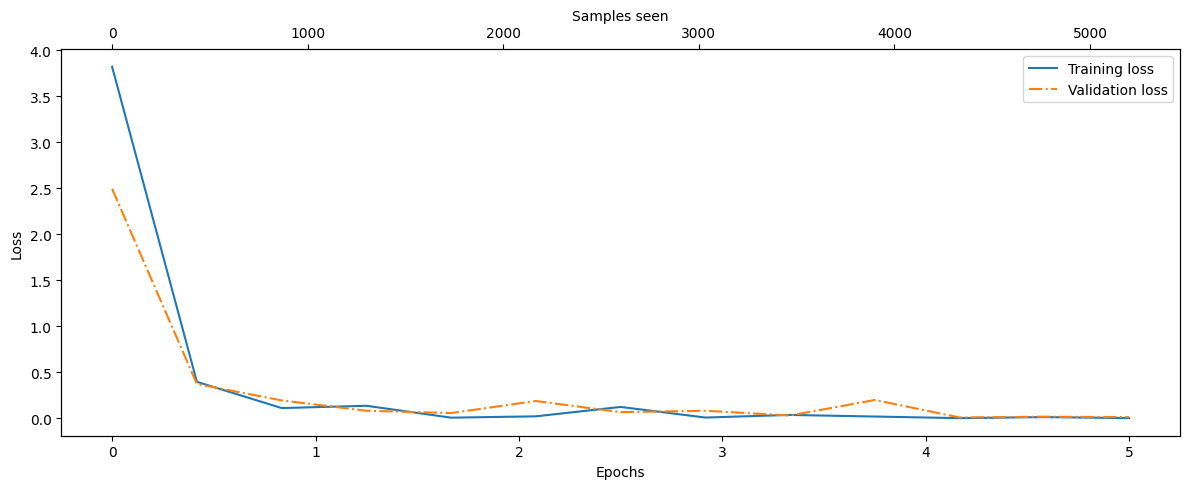

In [17]:
import matplotlib.pyplot as plt


def plot_values(
    epochs_seen: list[int],
    examples_seen: list[int],
    train_values: list[float],
    val_values: list[float],
    label: str,
):
    fig, ax1 = plt.subplots(figsize=(12, 5))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    # Invisible plot to set the ticks
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Samples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(
    epochs_seen=epochs_tensor.tolist(),
    examples_seen=examples_seen_tensor.tolist(),
    train_values=train_losses,
    val_values=val_losses,
    label="loss"
)

We can also calculate the accuracy for train, validation and test set.

In [16]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Train accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Train accuracy: 99.04%
Validation accuracy: 95.30%
Test accuracy: 97.67%


This shows that the model performs well across all data splits. Given we achieved this only training a small number of parameters this are very good results.